<a href="https://colab.research.google.com/github/jungyebin/Project2/blob/main/Busan_IT_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IT산업개발이 부산의 GRPD에 미치는 영향을 알아보기 위해, 2012년에 개발된  판교테크노벨리를 활용하여 분석

< IT 업계를 나타내기 위해 전체GRDP가 아닌 정보통신업의 GRDP로 분석>

---
1.판교테크노벨리는 2012년 조성이후 활발히 활동하고 있음 
- 판교테크노벨리 홈페이지의 연도별 게시물 갯수의 통계 사용

2.판교의 2012년 이후에 미치는 경제적 영향 
- 경기도 GRPD와 

- 판교 개발 이후를 비교하기 위해 중원구, 분당구의 부동산 가격 변화율 추이 활용

3.판교의 GRDP증가율을 부산시에 반영




**** 부산의 판교와 같은 IT산업단지가 유치된다면 부산의 GRDP를 예측***




# 패키지 설치

In [ ]:
!pip install selenium
!pip install pmdarima
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 21.3 MB/s 
     |████████████████████████████████| 139 kB 56.9 MB/s 
     |████████████████████████████████| 358 kB 60.2 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 4.1 MB 47.9 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.10 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in in

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from collections import Counter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import pmdarima as pm
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# colab 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# font 적용
plt.rc('font', family = 'NanumBarunGothic')

# ggplot 으로 그래프 스타일 설정
plt.style.use('ggplot')

# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'

# 데이터 수집

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bundang_real_estate = pd.read_csv('/content/drive/MyDrive/경기도 분당구 부동산매매동향.txt',sep='\t')
jungwon_real_estate = pd.read_csv('/content/drive/MyDrive/중원구_매매가격지수_종합.txt',sep='\t')
gyeonggi = pd.read_csv('/content/drive/MyDrive/시도별_경제활동별_지역내총생산_20220627010301.csv')
busan = pd.read_csv('/content/drive/MyDrive/시도별_경제활동별_지역내총생산_부산.csv')
population = pd.read_csv('/content/drive/MyDrive/시군구별_이동자수_20220704162632.csv')
aging = pd.read_csv('/content/drive/MyDrive/고령인구비율_시도_시_군_구__20220704171422.csv')

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)
url = 'https://www.pangyotechnovalley.org/html/support_biz/pangyo_support.asp'
driver.get(url)

selectbox = Select(driver.find_element(By.XPATH, '//*[@id="list_num_select"]'))
selectbox.select_by_value('100')
click = driver.find_element(By.XPATH, '//*[@id="module_board"]/div[1]/form[2]/fieldset/span/input').send_keys(Keys.ENTER)
d_page1 = driver.find_elements(By.XPATH,'//td[contains(@class,"day")]')
d_year=[]
for i in d_page1:
  d_year.append(i.text)

d_next = driver.find_element(By.XPATH, '//*[@id="module_board"]/div[4]/a').send_keys(Keys.ENTER)
d_page2 = driver.find_elements(By.XPATH,'//td[contains(@class,"day")]')
for i in d_page2:
  d_year.append(i.text)

d_year_list=[]  
for d in d_year:
  d_split = d.split('.')
  d_year = d_split[0]
  d_year_list.append(d_year)
d_year_list = d_year_list[20:] # 공지 중복으로 앞 20개 제거
#print(d_year_list)

# 데이터 정제

In [ ]:
def grdp(index):
  index = index.transpose().reset_index()
  index.columns = ['year','grdp']
  return index

def grdp_n(raw_index):
  index = raw_index.iloc[::2].reset_index()
  index = index.drop('index',axis=1)
  index = index.replace('2020 p)','2020')
  return index

def grdp_r(raw_index):
  index = raw_index.iloc[1::2].reset_index()
  index = index.drop('index', axis=1)
  index['year'] = [i.split('.')[0] for i in index['year']]
  index = index.replace('2020 p)','2020')
  return index

In [ ]:
bundang_real_estate = bundang_real_estate.transpose().reset_index()
dataframe1 = bundang_real_estate['index'][::2].reset_index().drop('level_0',axis=1)
dataframe2 = bundang_real_estate[1][1::2].reset_index().drop('index',axis=1)
bundang_real_estate = dataframe1.join(dataframe2)
bundang_real_estate['index'] = [i.split(' ')[0] for i in bundang_real_estate['index']]
bundang_real_estate[1] = pd.to_numeric(bundang_real_estate[1])
bundang_real_estate = bundang_real_estate.groupby('index').mean()
bundang_real_estate = bundang_real_estate.reset_index()
bundang_real_estate.columns = ['year','rate_of_change']

In [ ]:
jungwon_real_estate = jungwon_real_estate.transpose().reset_index()
dataframe1 = jungwon_real_estate['index'][::2].reset_index().drop('level_0',axis=1)
dataframe2 = jungwon_real_estate[1][1::2].reset_index().drop('index',axis=1)
jungwon_real_estate = dataframe1.join(dataframe2)
jungwon_real_estate['index'] = [i.split(' ')[0] for i in jungwon_real_estate['index']]
jungwon_real_estate[1] = pd.to_numeric(jungwon_real_estate[1])
jungwon_real_estate = jungwon_real_estate.groupby('index').mean()
jungwon_real_estate = jungwon_real_estate.reset_index()
jungwon_real_estate.columns = ['year','rate_of_change']
#print(jungwon_real_estate)

In [ ]:
gyeonggi = grdp(gyeonggi)
gyeonggi_n = grdp_n(gyeonggi)
gyeonggi_r = grdp_r(gyeonggi)

busan = grdp(busan)
busan_n = grdp_n(busan)
busan_r = grdp_r(busan)


population = population.transpose().reset_index()
aging_rate = aging.transpose().reset_index().iloc[::2]

# 2012년부터 판교테크노벨리지가 개발되었음

**2012년부터 판교테크노벨리지 홈페이지 개설을 시작해 현재까지 활성화가 이루어지고 있음** (단, 사업의 개수는 연도마다 다를 수 있음)

<BarContainer object of 10 artists>

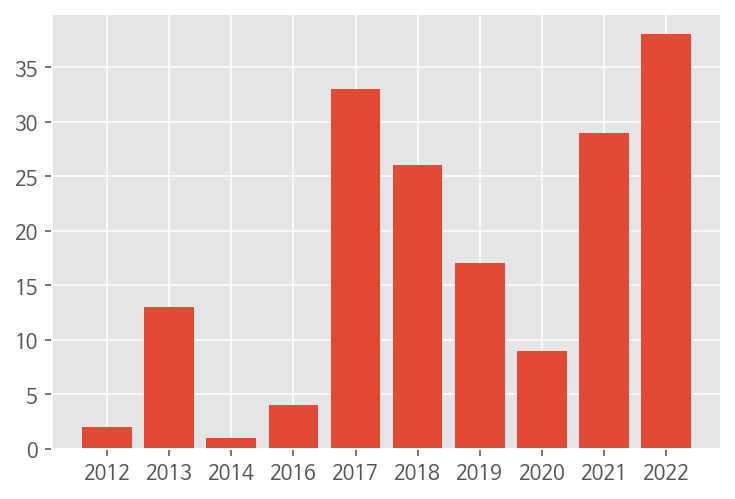

In [ ]:
count_year = Counter(sorted(d_year_list))
#print(count_year)

_, axe = plt.subplots()
axe.bar(list(count_year), count_year.values())

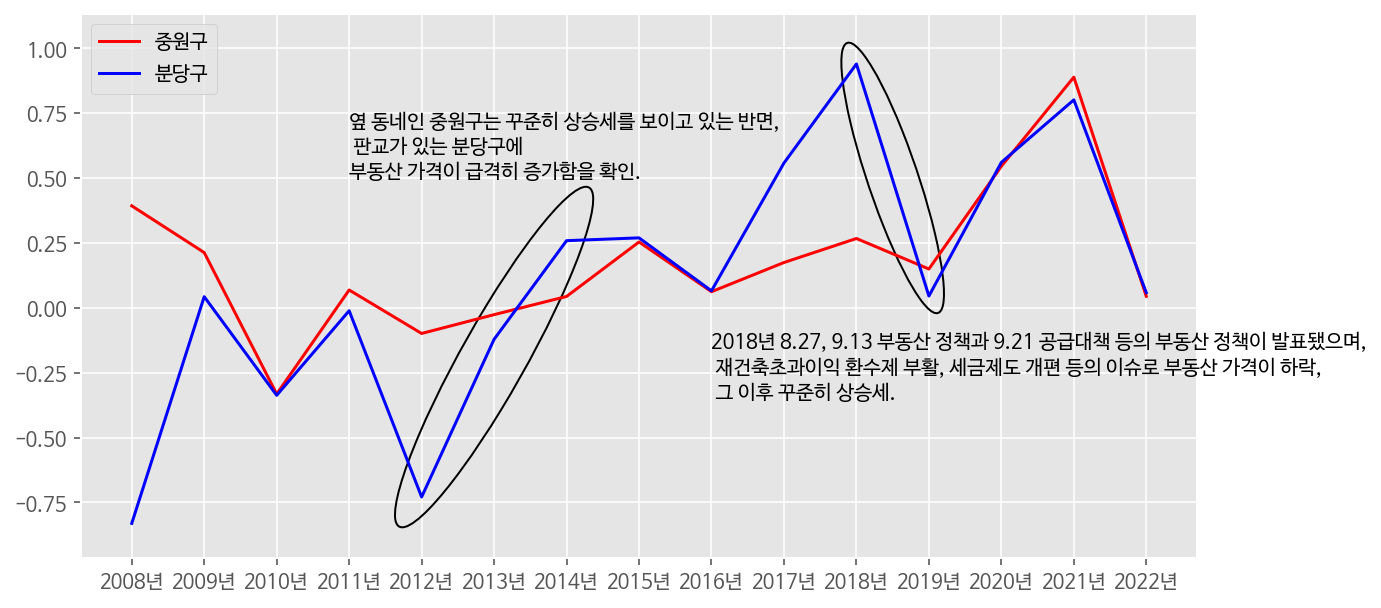

In [ ]:
_, axe = plt.subplots(figsize=(10, 5))
axe.plot(jungwon_real_estate['year'], jungwon_real_estate['rate_of_change'],c='r',label='중원구')
axe.plot(bundang_real_estate['year'], bundang_real_estate['rate_of_change'],c='b', label = '분당구')
axe.annotate('옆 동네인 중원구는 꾸준히 상승세를 보이고 있는 반면,\n 판교가 있는 분당구에 \n부동산 가격이 급격히 증가함을 확인.', xy=('2011년', 0.5))
axe.annotate('2018년 8.27, 9.13 부동산 정책과 9.21 공급대책 등의 부동산 정책이 발표됐으며,\n 재건축초과이익 환수제 부활, 세금제도 개편 등의 이슈로 부동산 가격이 하락,\n 그 이후 꾸준히 상승세. ', xy=('2016년', -0.35))
axe.legend()

patch1 = patches.Ellipse([5,-0.19],3,0.45, fc='none', ls='solid', ec='black', lw='1', angle=24.55)
patch2 = patches.Ellipse([10.5,0.5],1.7,0.45, fc='none', ls='solid', ec='black', lw='1', angle=-35)
axe.add_patch(patch1)
axe.add_patch(patch2)

# 경기도의 명목GRDP와 실질GRDP

명목GRDP는 물가 변동을 반영하지 않은 것이고, 실질GRDP는 물가 변동을 반영한 것

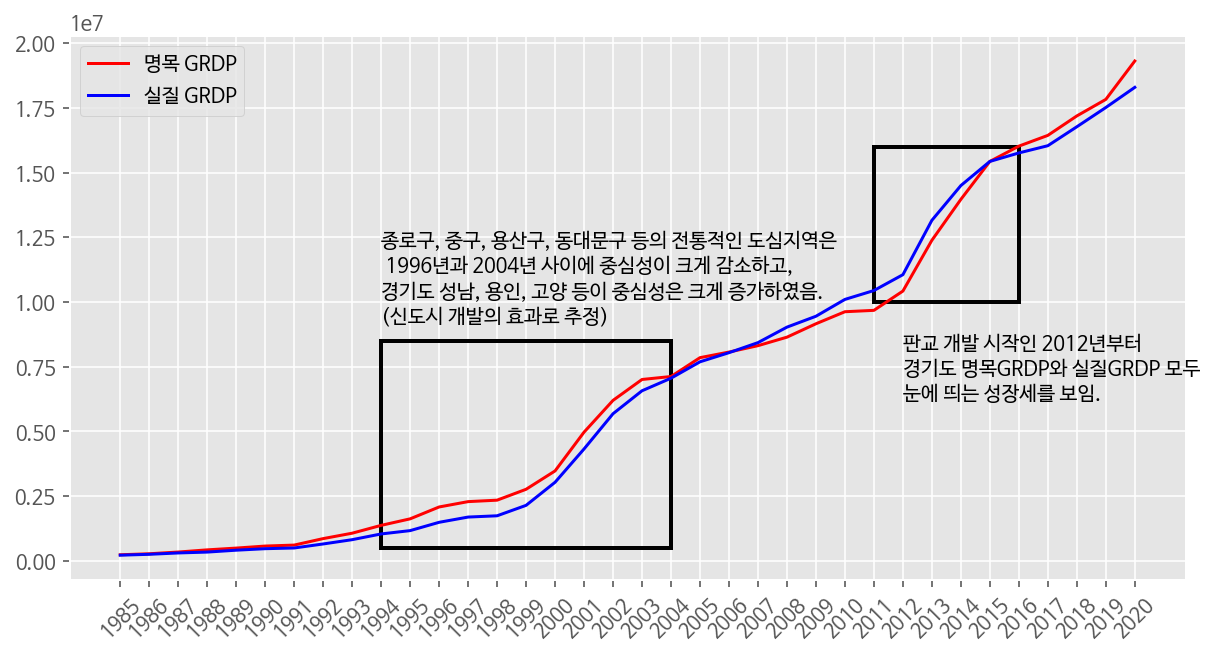

In [ ]:
_, axe = plt.subplots(figsize=(10,5))
axe.plot(gyeonggi_n['year'], gyeonggi_n['grdp'],c='r', label='명목 GRDP')
axe.plot(gyeonggi_r['year'], gyeonggi_r['grdp'], c='b', label='실질 GRDP')
axe.tick_params(axis='x',rotation=45)
axe.annotate('종로구, 중구, 용산구, 동대문구 등의 전통적인 도심지역은\n 1996년과 2004년 사이에 중심성이 크게 감소하고, \n경기도 성남, 용인, 고양 등이 중심성은 크게 증가하였음.\n(신도시 개발의 효과로 추정)', xy=(9,9200000))
axe.annotate('판교 개발 시작인 2012년부터 \n경기도 명목GRDP와 실질GRDP 모두 \n눈에 띄는 성장세를 보임.', xy=(27,6200000))
axe.legend()

patch1 = patches.Rectangle((9,500000),10,8000000, fc='none', ec='black', lw='2')
patch2 = patches.Rectangle((26,10000000),5,6000000, fc='none', ec='black', lw='2')
axe.add_patch(patch1)
axe.add_patch(patch2)



```
# 판교개발이 이루어진 경우
```
 명목GRDP **19,308,265백만원**, 실질GRDP는 **18,290,686백만원**

```
# 판교개발이 이루어지지 않은 경우
```
 명목GRDP 약**13,411,329백만원**, 실질GRDP 약 **13,703,325**백만원으로 예측.





In [ ]:
from sklearn.linear_model import LinearRegression, Lasso,Ridge
X_n = gyeonggi_n['year'].values
y_n = gyeonggi_n['grdp'].values
(X_n_train, y_n_train) = X_n[:28], y_n[:28]

reg_n = LinearRegression()
reg_n.fit(X_n_train[:, np.newaxis],y_n_train)

X_r = gyeonggi_r['year'].values
y_r = gyeonggi_r['grdp'].values
(X_r_train, y_r_train) = X_r[:28], y_r[:28]

reg_r = LinearRegression()
reg_r.fit(X_r_train[:, np.newaxis], y_r_train)

LinearRegression()

Text(2020, 18290686, '18,290,686백만원')

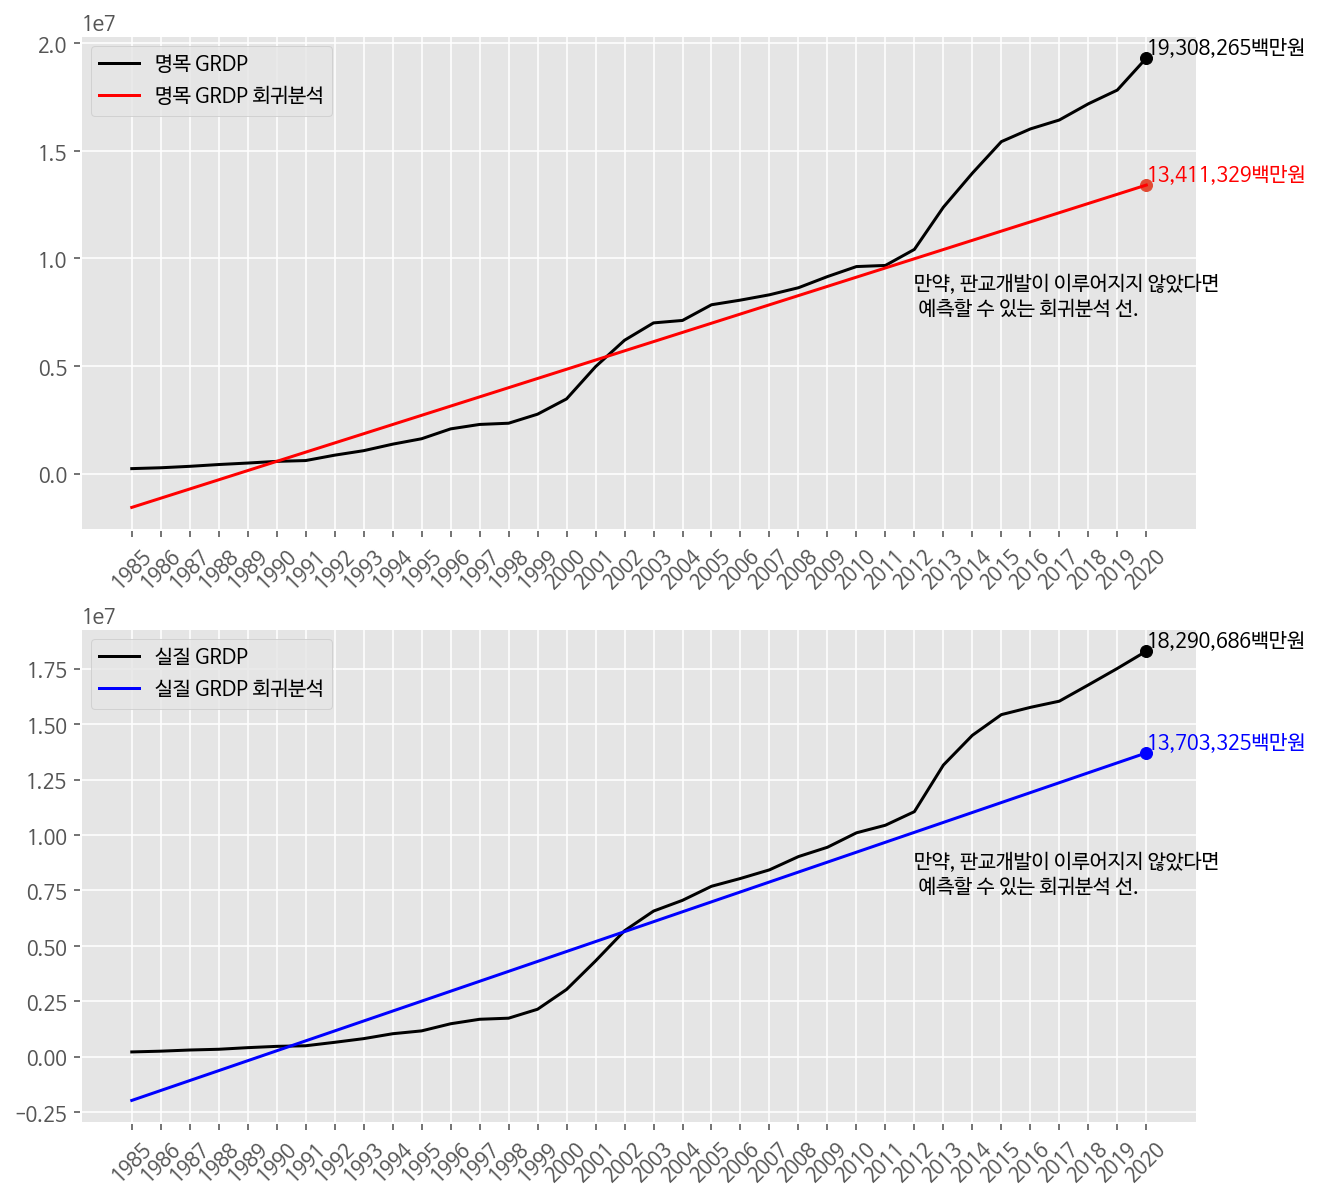

In [ ]:
scatter_n = 2020*reg_n.coef_+reg_n.intercept_
fig = plt.figure(figsize=(10,10))
nominal = fig.add_subplot(2,1,1)
real = fig.add_subplot(2,1,2)
nominal.plot(gyeonggi_n['year'], gyeonggi_n['grdp'],c ='black',label='명목 GRDP')
nominal.plot(X_n, reg_n.predict(X_n.reshape(-1,1)), c='r',label = '명목 GRDP 회귀분석')
nominal.tick_params(axis='x',rotation=45)
nominal.scatter('2020', scatter_n)
nominal.scatter('2020', 19308265, c='black')
nominal.legend()
nominal.annotate('만약, 판교개발이 이루어지지 않았다면\n 예측할 수 있는 회귀분석 선.', xy=(27,7400000))
nominal.text('2020',scatter_n,format((round(scatter_n[0])),',')+'백만원',horizontalalignment='left', verticalalignment='bottom',c='r')
nominal.text('2020',19308265,format(19308265,',')+'백만원',horizontalalignment='left', verticalalignment='bottom',c='black')

scatter_r = 2020*reg_r.coef_+reg_r.intercept_
real.plot(gyeonggi_r['year'], gyeonggi_r['grdp'],c ='black',label='실질 GRDP')
real.plot(X_r, reg_r.predict(X_r.reshape(-1,1)), c='b',label = '실질 GRDP 회귀분석')
real.tick_params(axis='x',rotation=45)
real.scatter('2020', scatter_r, c='b')
real.scatter('2020', 18290686, c='black')
real.legend()
real.annotate('만약, 판교개발이 이루어지지 않았다면\n 예측할 수 있는 회귀분석 선.', xy=(27,7400000))
real.text('2020',scatter_r,format((round(scatter_r[0])),',')+'백만원',horizontalalignment='left', verticalalignment='bottom',c='b')
real.text('2020',18290686,format(18290686,',')+'백만원',horizontalalignment='left', verticalalignment='bottom',c='black')

# 부산시 예상 명목GDPR 추정




부산시(시장 박형준)는 도심융합특구 사업지구로 센텀2 도시첨단산업단지(191만㎡, 이하 센텀2지구)가 선정됐다고 밝혔다.

도심융합특구는 수도권을 제외한 5대 광역시 도심에  **판교 제2테크노밸리 모델**을 적용해 기업과 청년에게 매력적인 복합혁신공간을 만들어 제공하는 것으로, 도심에 창업·벤처 등 범정부가 추진하는 지원사업을 집적하고 산업, 주거, 문화 등이 집약된 우수한 인프라를 갖춘 고밀도 거점 공간을 조성한다.

대상지로 선정된 센텀2지구는 부산 대개조 프로젝트 일환으로 해운대구 반여동·반송동·석대동 일원에 **2027년 완공을 목표로** 부산도시공사와 함께 도시첨단산업단지 조성을 추진 중이며, 또한 센텀시티, 해운대와 인접해 우수한 주거․상업․문화 인프라를 활용할 수 있으며, 도시철도 4호선, 반송로 등 시내 교통망 및 경부고속도로 등 광역교통망 접근성도 우수하다.

이를 통해 센텀2지구를 창업·벤처기업 등이 공존하는 ICT(정보통신기술) 중심의 미래 산업 생태계로 조성하고 매력적인 주거․상업․문화 복합공간도 함께 마련하여 우수한 지역 인재들의 정착을 도모할 예정이다.

출처 : 전기신문(https://www.electimes.com)

Text(2004, 950000, '2005년부터 부산 청년층 인구유출,\n 고령화으로 생산가능인구가 감소, 고부가가치 산업 부진으로\n 전국적으로 GRDP는 높은편이지만, 인구대비 낮은편\n(출처:한국은행 부산본부(2020), 부산경제 현황과 과제)')

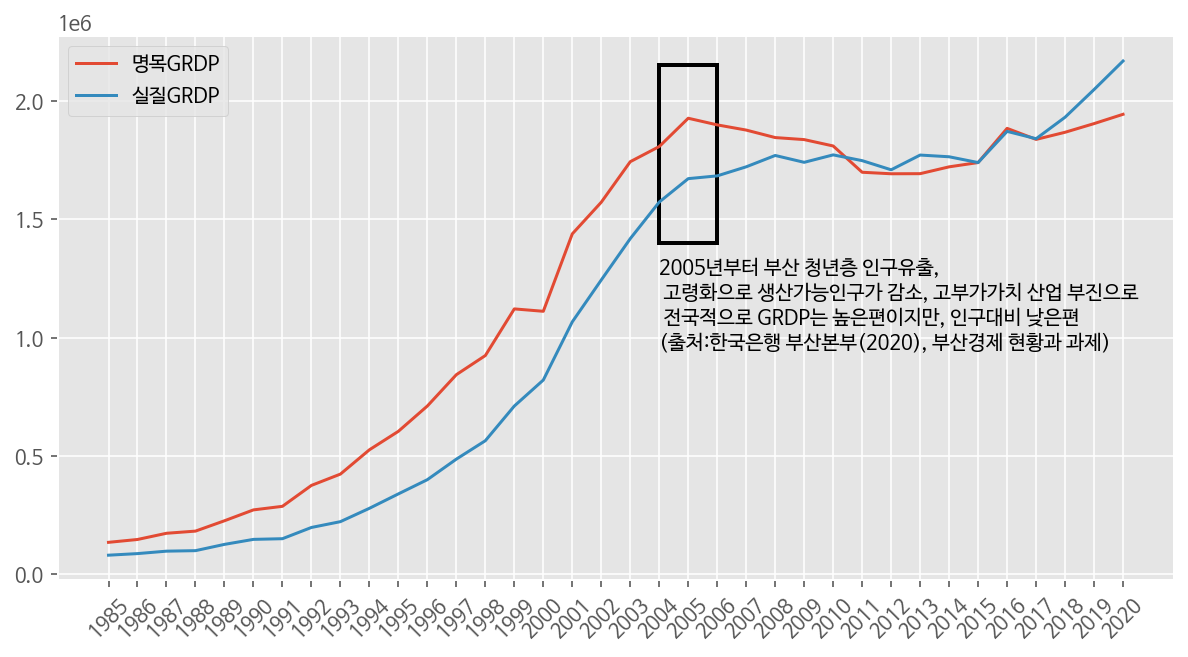

In [ ]:
_,axe = plt.subplots(figsize=(10,5))
axe.plot(busan_n['year'], busan_n['grdp'], label = '명목GRDP')
axe.plot(busan_r['year'], busan_r['grdp'], label= '실질GRDP')
axe.tick_params(axis='x',rotation=45)
axe.legend()


patch1 = patches.Rectangle((19,1400000),2,750000, fc='none', ec='black', lw='2')
axe.add_patch(patch1)
axe.annotate('2005년부터 부산 청년층 인구유출,\n 고령화으로 생산가능인구가 감소, 고부가가치 산업 부진으로\n 전국적으로 GRDP는 높은편이지만, 인구대비 낮은편\n(출처:한국은행 부산본부(2020), 부산경제 현황과 과제)', xy=('2004',950000))

Text(0.5, 1.0, '고령인구비율')

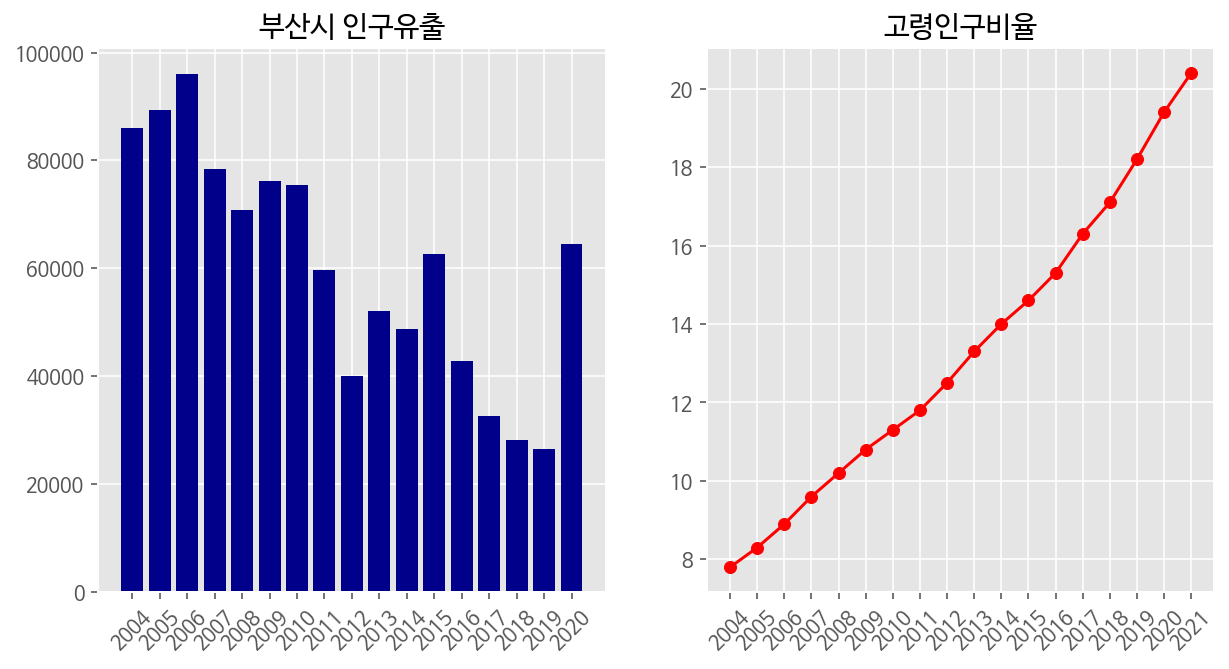

In [ ]:
fig = plt.figure(figsize=(10,5))
p = fig.add_subplot(1,2,1)
a = fig.add_subplot(1,2,2)
p.bar(population['index'], population[0]-150000,color='darkblue')
p.tick_params(axis='x',rotation=45)
p.set_title('부산시 인구유출')

a.plot(aging_rate['index'], aging_rate[0], color='red')
a.scatter(aging_rate['index'], aging_rate[0], color='red')
a.tick_params(axis='x',rotation=45)
a.set_title('고령인구비율')

In [ ]:
# 부산의 grdp증가율 예측
# - 시계열 데이터를 추정할 수 있는 ARIMA모형 활용
# - IT버블이나 금융위기, 부산경제 침체 등 다른변수는 없다고 가정
# - 실질GRDP는 물가상승률을 반영하기 때문에 명목GRDP만 추정
# - 다른 업종이 정보통신업에 끼치는 영향은 없다고 가정
# - 판교개발 이후의 명목GRDP 증가율 그대로 반영

In [ ]:
busan_n = grdp_n(busan)
busan_n['year'] = pd.to_datetime(busan_n['year'],format='%Y').dt.year
busan_n = busan_n.set_index('year')
busan_n['grdp'].astype(float)
train = busan_n[:].astype(float)
#print(train)

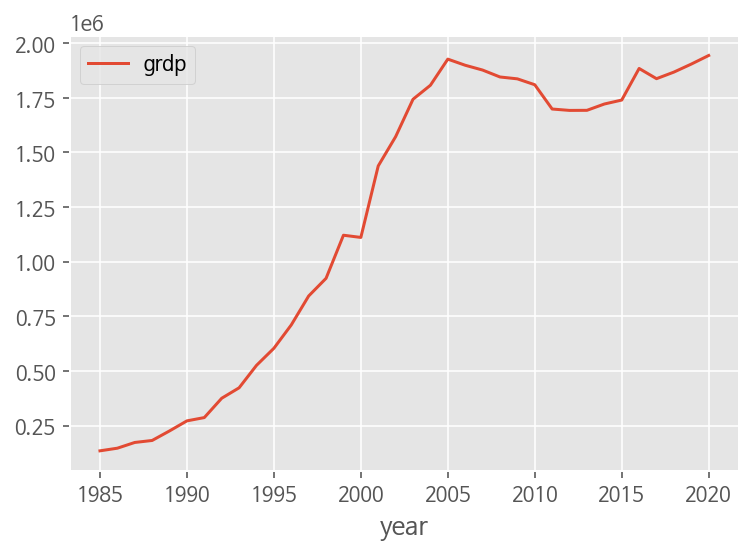

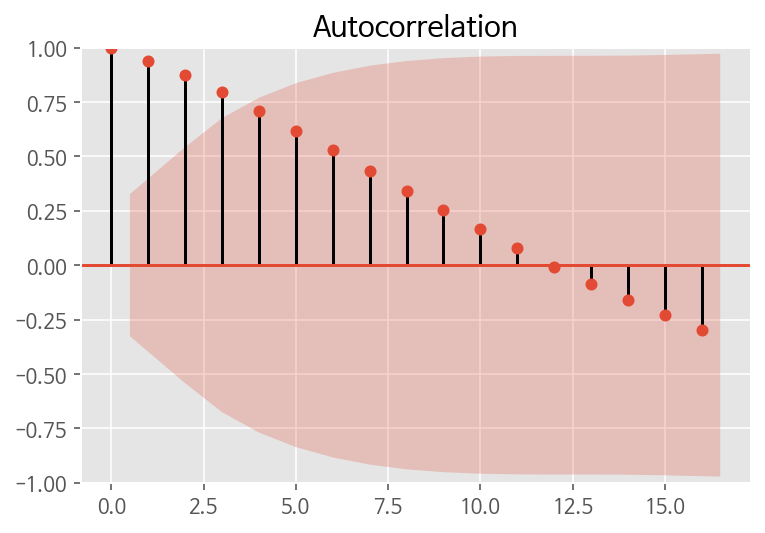

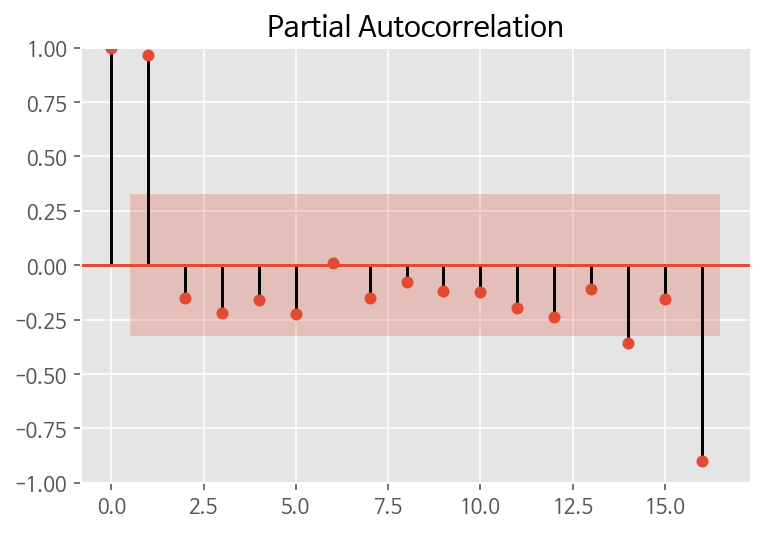

<Figure size 1440x288 with 0 Axes>

In [ ]:
train.plot()
plt.show()
plot_acf(train)
# acf를 보면 약 11의 time lag를 기준으로 양에서 음으로 변동
plot_pacf(train)
# pacf는 1의 time lag에서 약 0.9를 보이고 이후 급격히 감소
plt.figure(figsize=(20,4))
plt.show()

<function matplotlib.pyplot.show>

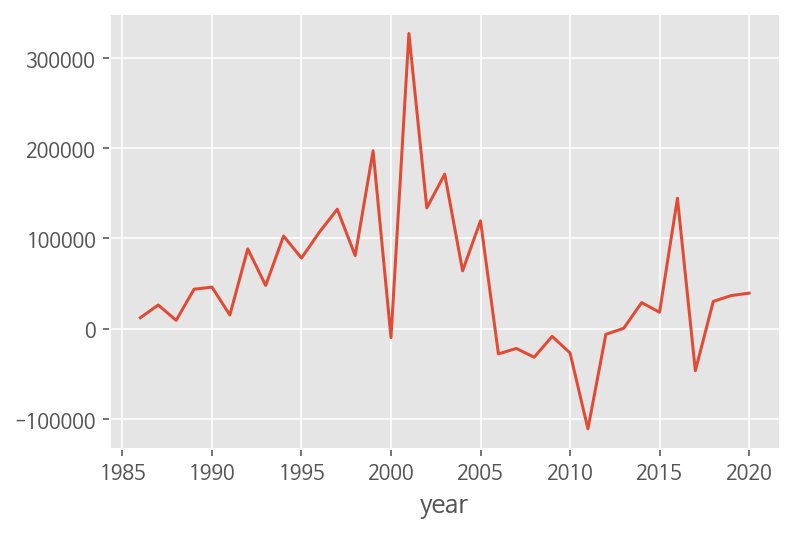

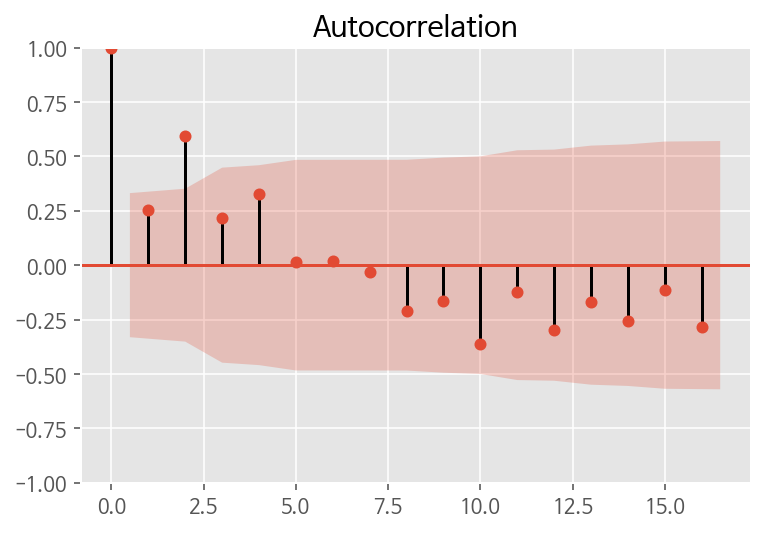

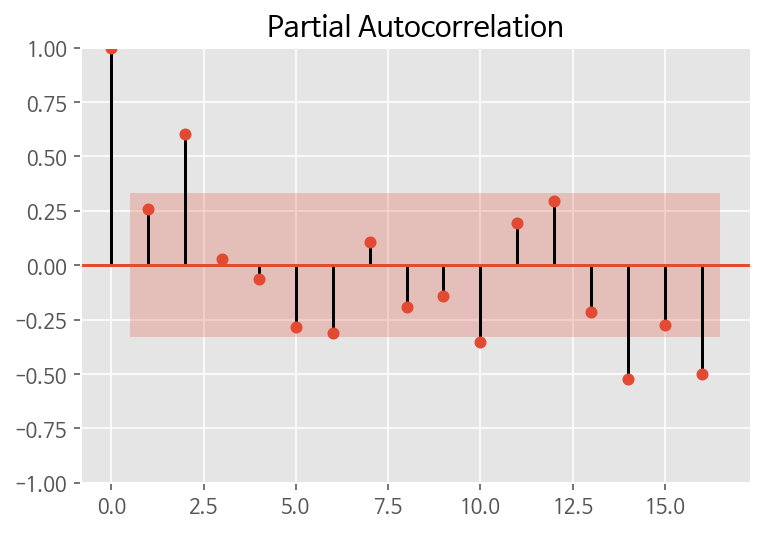

In [ ]:
diff_1 = train['grdp'].diff(periods=1).iloc[1:] #차분진행
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show

In [ ]:
predict = pm.auto_arima(train,d = 1, seasonal = False, trace = True)
print(predict)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=887.458, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=894.385, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=894.423, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=895.776, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=904.381, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=886.890, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=889.775, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=894.747, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=890.044, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=890.926, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=886.074, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.981, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=886.015, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=888.039, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=883.1

In [ ]:
model = ARIMA(train['grdp'], order =(2,1,0))
model_fit = model.fit()
print(model_fit.summary())
# 유의확률 유의미하다고 판단

                               SARIMAX Results                                
Dep. Variable:                   grdp   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -438.593
Date:                Sat, 09 Jul 2022   AIC                            883.185
Time:                        01:51:06   BIC                            887.851
Sample:                             0   HQIC                           884.796
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1619      0.111      1.452      0.147      -0.057       0.380
ar.L2          0.5957      0.090      6.635      0.000       0.420       0.772
sigma2      4.549e+09   7.56e-12   6.01e+20      0.0

In [ ]:
start_date = '20210101'
end_date = '20310101'
date_list = pd.date_range(start = start_date, end= end_date, freq='Y')

y_pred = model_fit.forecast(steps=10)
predict_grdp_n = pd.DataFrame(date_list, y_pred).reset_index()
predict_grdp_n.columns=['grdp','year']
predict_grdp_n['year'] = pd.to_datetime(predict_grdp_n['year'],format='%Y').dt.year
predict_grdp_n = predict_grdp_n.set_index('year')
predict_grdp_n = pd.concat([train,predict_grdp_n],axis=0)

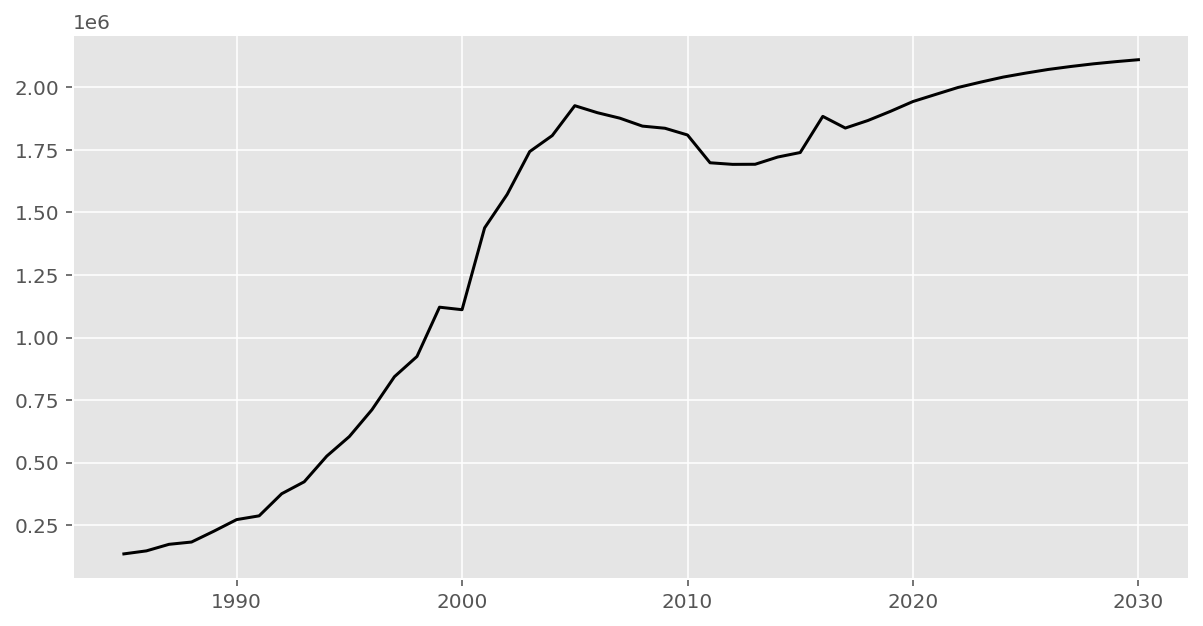

In [ ]:
_,axe = plt.subplots(figsize=(10,5))
axe.plot(predict_grdp_n,c='black')

Text(2030, 2110927.0, '만약, 센텀2도시 개발이 이루어지지 않을 경우')

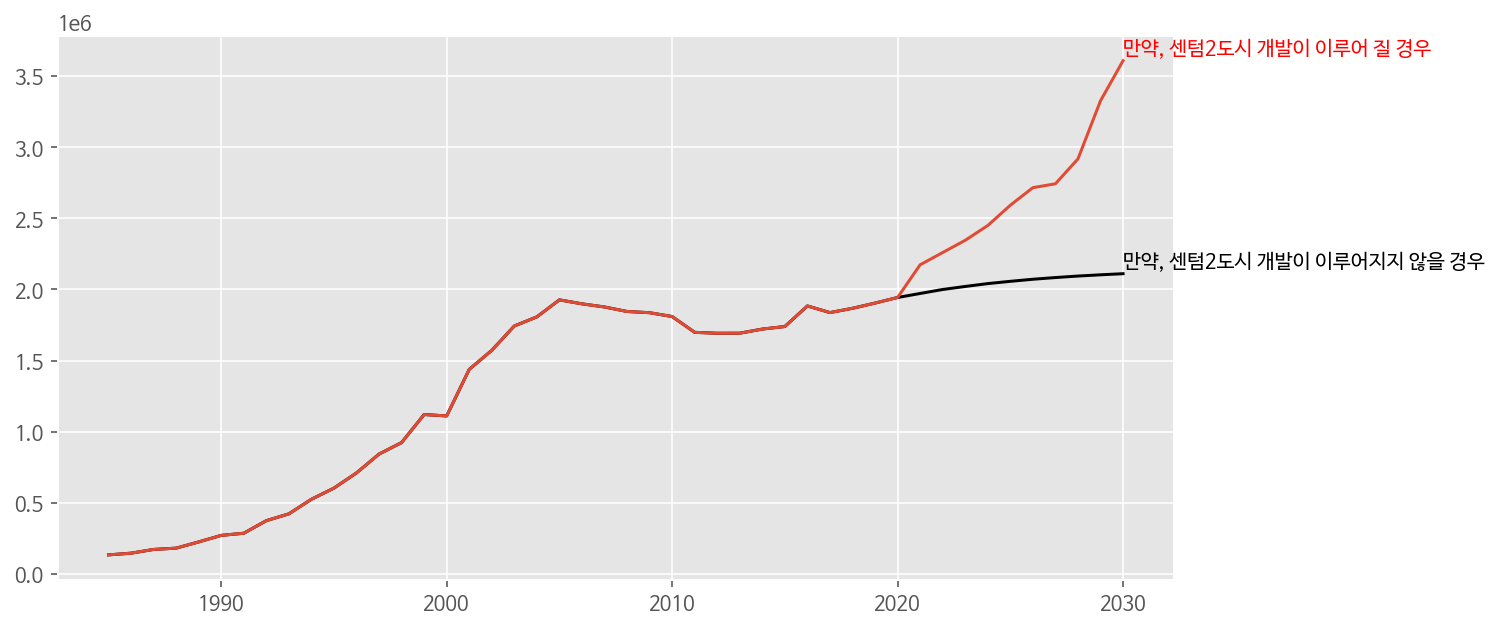

In [ ]:
# 경기도 grdp증가율계산
increase_n = []
for n in range(35):
  i = (gyeonggi_n['grdp'][n+1]-gyeonggi_n['grdp'][n])/gyeonggi_n['grdp'][n]
  n=+1
  increase_n.append(i)
increase_n = increase_n[19:30]
list1 = [1]*10
increase=[]
n=0
for i in range(0,10):
  n = n + increase_n[i]
  increase.append(n)
rate = [x+y for x,y in zip(increase,list1)]

increase_grdp = predict_grdp_n[-10:]['grdp']*rate

increase_grdp = increase_grdp.reset_index().set_index('year')
increase_grdp_n = pd.concat([train, increase_grdp])

_,axe = plt.subplots(figsize=(10,5))
axe.plot(predict_grdp_n,c='black')
axe.plot(increase_grdp_n)
axe.text(2030,3.607763e+06,'만약, 센텀2도시 개발이 이루어 질 경우',horizontalalignment='left', verticalalignment='bottom',c='r')
axe.text(2030,2.110927e+06,'만약, 센텀2도시 개발이 이루어지지 않을 경우',horizontalalignment='left', verticalalignment='bottom',c='black')

Text(2030, 2110927.0, '약 1,975,940백만원')

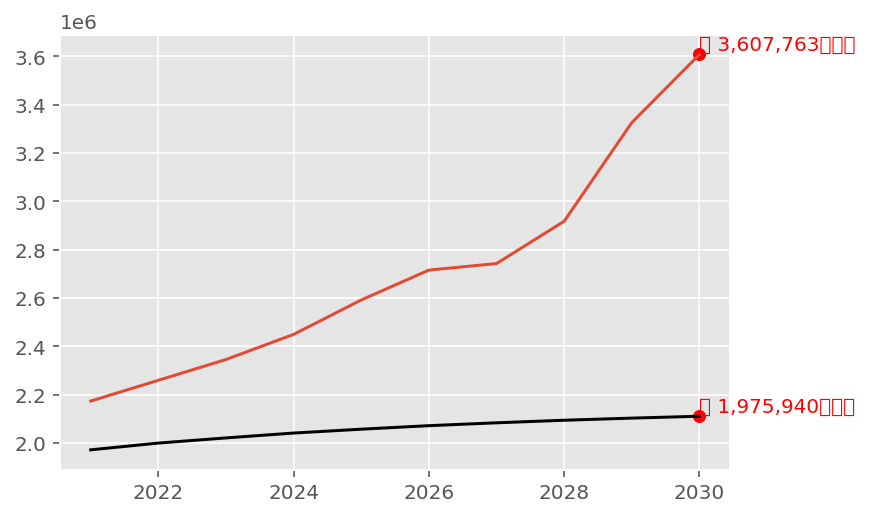

In [ ]:
#2020년 이후 그래프

_, axe = plt.subplots()
axe.plot(increase_grdp)
axe.plot(predict_grdp_n[-10:]['grdp'],c='black')

axe.scatter(2030, 3.607763e+06, c='r')
axe.text(2030,3.607763e+06,'약 3,607,763백만원',horizontalalignment='left', verticalalignment='bottom',c='r')
axe.scatter(2030, 2.110927e+06, c='r')
axe.text(2030,2.110927e+06,'약 1,975,940백만원',horizontalalignment='left', verticalalignment='bottom',c='r')

# 2027년에 부산에 제2 테크노벨리가 신설된다면 2030년 예상grdp는 약 3,607,763백만원으로 추정됨